The very first problem that I had was that I imported about 2 weeks worth of data and the amount was so huge, that I could not even edit the dataframe and add a new column to it. Next I tried to import a smaller amount of data. I imported a day. Even that was too big. In the end I ended up working with a couple of hours worth of data, because otherwise my computer was not able to handle it and I had to spend huge amounts of time just waiting for the code to do something.

For actual implementation it is important to use a bigger amount of data obviously. But that would also require a better computer.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


df = pd.read_csv("BTCUSDT_2020.11.30-2020.11.30_ML.csv")
print(df.head())

            time     price  close        RSI     RMACD       RSD  DBB  \
0  1606687201150  18254.99      0  58.318787 -0.954874  2.919877  0.0   
1  1606687201391  18255.00      0  58.321123 -0.954737  2.919883  0.0   
2  1606687201400  18255.29      0  58.388949 -0.950777  2.920073  0.0   
3  1606687201510  18255.28      0  58.386607 -0.950914  2.920067  0.0   
4  1606687201510  18255.14      0  58.353847 -0.952825  2.919974  0.0   

     REMA_9    REMA_21    REMA_50  
0 -7.998948  11.619434  45.995590  
1 -7.994568  11.624419  46.000876  
2 -7.867556  11.768988  46.154180  
3 -7.871936  11.764003  46.148894  
4 -7.933252  11.694211  46.074885  


This loop is meant to calculate the 'y' column values. For each row the y value will be the maximum price of the next 100 row prices.

Also tried with 1000 but I don't see any point in adding another block of code for this, since it is literally just adding one zero to three places.

In [2]:
max_price = 0.0
pricearray = df["price"].values
y = []
for i in range(len(pricearray)):
    for j in range(100):
        if pricearray[i+j+1] > max_price:
            max_price = pricearray[i+j+1]
    y.append(max_price)
    max_price = 0.0
    if i == len(pricearray)-101:
        break
df.drop(df.tail(100).index,inplace=True)
df["y"] = y
X_train = df.drop(['y'], axis=1)
y_train = df['y']
print(df)


                time     price  close        RSI      RMACD       RSD  DBB  \
0      1606687201150  18254.99      0  58.318787  -0.954874  2.919877  0.0   
1      1606687201391  18255.00      0  58.321123  -0.954737  2.919883  0.0   
2      1606687201400  18255.29      0  58.388949  -0.950777  2.920073  0.0   
3      1606687201510  18255.28      0  58.386607  -0.950914  2.920067  0.0   
4      1606687201510  18255.14      0  58.353847  -0.952825  2.919974  0.0   
...              ...       ...    ...        ...        ...       ...  ...   
40196  1606690783984  18131.87      0  44.717926  13.686486  4.339018  0.0   
40197  1606690784231  18132.59      0  44.813073  13.643993  4.337460  0.0   
40198  1606690784693  18132.60      0  44.814398  13.643402  4.337438  0.0   
40199  1606690784953  18132.59      0  44.813073  13.643993  4.337460  0.0   
40200  1606690785197  18132.60      0  44.814398  13.643402  4.337438  0.0   

         REMA_9    REMA_21    REMA_50         y  
0     -7.9989

Before this block I spent quite a large amount of time learning about what exactly the random forest models hyperparameters do, how I should tweak them and what changes they bring. After learning about them I found out about a module called RandomizedSearchCV (and also GridSearchCV). It can help find good hyperparameters for the model. I have talked about the GridSearchCV module a little bit more down below and actually what I should have kept in mind in the first place before optimizing any hyperparameters, but RandomizedSearchCV is actually quite quick. I inserted some values, then changed them according to the results and repeated that process for some times, this way I got a pretty good understanding about what good parameters could be like.

RandomizedSearchCV is okay to use with relatively large amount of values, because it is fast, but GridSearchCV is really slow and I think I definitely should have done some plotting before using GridSearchCV (and maybe even before using RandomizedSearchCV).


In [3]:
from sklearn import preprocessing
from sklearn import utils
from joblib import parallel_backend
from joblib import dump, load
from scipy import stats
import numpy as np

n_estimators = [1500, 1550, 1590, 1595, 1599, 2000, 2005, 2010, 2015, 2020, 2050]
max_samples = [900, 1000, 1100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [80, 85, 90, 95, 100, 105]

max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Minimum number of leaf nodes required
max_leaf_nodes = [250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_samples': max_samples,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes':max_leaf_nodes,
               'bootstrap': bootstrap}

rf = RandomForestRegressor(n_jobs=-1, verbose=1)
#print(rf.get_params().keys())
random_search = RandomizedSearchCV(estimator=rf, random_state=0, param_distributions=random_grid,
                        n_iter=10, cv=3, verbose=10, n_jobs=1, pre_dispatch=1)
 
#Code to save the model into a file so it would be possible to reload it into the project fast
#and skip all the training.
#dump(rf, 'randomforest.joblib')
#rf = load('randomforest.joblib')


The next cell shows the fitting but also a joblib parallel_backend method, that we did not use in the course, but might become very useful when working with larger amounts of data and more complex models.

In [4]:
with parallel_backend('threading'):
    random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=300, max_features=auto, max_depth=105, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Para

[CV]  n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=300, max_features=auto, max_depth=105, bootstrap=False, score=0.563, total= 1.2min
[CV] n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=300, max_features=auto, max_depth=105, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=300, max_features=auto, max_depth=105, bootstrap=False, score=0.949, total= 1.5min
[CV] n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=300, max_features=auto, max_depth=105, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=300, max_features=auto, max_depth=105, bootstrap=False, score=0.811, total= 1.3min
[CV] n_estimators=2010, min_samples_split=2, min_samples_leaf=3, max_samples=1100, max_leaf_nodes=350, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2010 out of 2010 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2010, min_samples_split=2, min_samples_leaf=3, max_samples=1100, max_leaf_nodes=350, max_features=sqrt, max_depth=90, bootstrap=True, score=0.479, total=   4.8s
[CV] n_estimators=2010, min_samples_split=2, min_samples_leaf=3, max_samples=1100, max_leaf_nodes=350, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2010 out of 2010 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2010, min_samples_split=2, min_samples_leaf=3, max_samples=1100, max_leaf_nodes=350, max_features=sqrt, max_depth=90, bootstrap=True, score=0.905, total=   4.7s
[CV] n_estimators=2010, min_samples_split=2, min_samples_leaf=3, max_samples=1100, max_leaf_nodes=350, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2010 out of 2010 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2010, min_samples_split=2, min_samples_leaf=3, max_samples=1100, max_leaf_nodes=350, max_features=sqrt, max_depth=90, bootstrap=True, score=0.428, total=   4.6s
[CV] n_estimators=2005, min_samples_split=6, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=250, max_features=sqrt, max_depth=95, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   25.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=6, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=250, max_features=sqrt, max_depth=95, bootstrap=False, score=0.470, total=  26.9s
[CV] n_estimators=2005, min_samples_split=6, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=250, max_features=sqrt, max_depth=95, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   23.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=6, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=250, max_features=sqrt, max_depth=95, bootstrap=False, score=0.891, total=  25.0s
[CV] n_estimators=2005, min_samples_split=6, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=250, max_features=sqrt, max_depth=95, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   25.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=6, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=250, max_features=sqrt, max_depth=95, bootstrap=False, score=0.604, total=  26.8s
[CV] n_estimators=2050, min_samples_split=4, min_samples_leaf=5, max_samples=1100, max_leaf_nodes=350, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2050 out of 2050 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2050, min_samples_split=4, min_samples_leaf=5, max_samples=1100, max_leaf_nodes=350, max_features=auto, max_depth=80, bootstrap=False, score=0.564, total= 1.2min
[CV] n_estimators=2050, min_samples_split=4, min_samples_leaf=5, max_samples=1100, max_leaf_nodes=350, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2050 out of 2050 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2050, min_samples_split=4, min_samples_leaf=5, max_samples=1100, max_leaf_nodes=350, max_features=auto, max_depth=80, bootstrap=False, score=0.948, total= 1.3min
[CV] n_estimators=2050, min_samples_split=4, min_samples_leaf=5, max_samples=1100, max_leaf_nodes=350, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2050 out of 2050 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2050, min_samples_split=4, min_samples_leaf=5, max_samples=1100, max_leaf_nodes=350, max_features=auto, max_depth=80, bootstrap=False, score=0.811, total= 1.2min
[CV] n_estimators=2005, min_samples_split=4, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=450, max_features=sqrt, max_depth=95, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   24.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=4, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=450, max_features=sqrt, max_depth=95, bootstrap=False, score=0.472, total=  26.4s
[CV] n_estimators=2005, min_samples_split=4, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=450, max_features=sqrt, max_depth=95, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   25.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=4, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=450, max_features=sqrt, max_depth=95, bootstrap=False, score=0.890, total=  26.5s
[CV] n_estimators=2005, min_samples_split=4, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=450, max_features=sqrt, max_depth=95, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   24.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=4, min_samples_leaf=3, max_samples=1000, max_leaf_nodes=450, max_features=sqrt, max_depth=95, bootstrap=False, score=0.581, total=  25.5s
[CV] n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=450, max_features=auto, max_depth=90, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=450, max_features=auto, max_depth=90, bootstrap=False, score=0.563, total= 1.3min
[CV] n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=450, max_features=auto, max_depth=90, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=450, max_features=auto, max_depth=90, bootstrap=False, score=0.949, total= 1.3min
[CV] n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=450, max_features=auto, max_depth=90, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2020, min_samples_split=3, min_samples_leaf=5, max_samples=1000, max_leaf_nodes=450, max_features=auto, max_depth=90, bootstrap=False, score=0.813, total= 1.5min
[CV] n_estimators=2015, min_samples_split=3, min_samples_leaf=5, max_samples=900, max_leaf_nodes=550, max_features=sqrt, max_depth=105, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2015 out of 2015 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2015, min_samples_split=3, min_samples_leaf=5, max_samples=900, max_leaf_nodes=550, max_features=sqrt, max_depth=105, bootstrap=True, score=0.475, total=  13.8s
[CV] n_estimators=2015, min_samples_split=3, min_samples_leaf=5, max_samples=900, max_leaf_nodes=550, max_features=sqrt, max_depth=105, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2015 out of 2015 | elapsed:    7.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2015, min_samples_split=3, min_samples_leaf=5, max_samples=900, max_leaf_nodes=550, max_features=sqrt, max_depth=105, bootstrap=True, score=0.904, total=  12.0s
[CV] n_estimators=2015, min_samples_split=3, min_samples_leaf=5, max_samples=900, max_leaf_nodes=550, max_features=sqrt, max_depth=105, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 2015 out of 2015 | elapsed:   11.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2015, min_samples_split=3, min_samples_leaf=5, max_samples=900, max_leaf_nodes=550, max_features=sqrt, max_depth=105, bootstrap=True, score=0.429, total=  16.7s
[CV] n_estimators=1595, min_samples_split=3, min_samples_leaf=1, max_samples=1000, max_leaf_nodes=650, max_features=sqrt, max_depth=105, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1595 out of 1595 | elapsed:    8.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 1595 out of 1595 | elapsed:    1.7s finished


[CV]  n_estimators=1595, min_samples_split=3, min_samples_leaf=1, max_samples=1000, max_leaf_nodes=650, max_features=sqrt, max_depth=105, bootstrap=True, score=0.476, total=  12.8s
[CV] n_estimators=1595, min_samples_split=3, min_samples_leaf=1, max_samples=1000, max_leaf_nodes=650, max_features=sqrt, max_depth=105, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1595 out of 1595 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 1595 out of 1595 | elapsed:    1.8s finished


[CV]  n_estimators=1595, min_samples_split=3, min_samples_leaf=1, max_samples=1000, max_leaf_nodes=650, max_features=sqrt, max_depth=105, bootstrap=True, score=0.900, total=  13.2s
[CV] n_estimators=1595, min_samples_split=3, min_samples_leaf=1, max_samples=1000, max_leaf_nodes=650, max_features=sqrt, max_depth=105, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1595 out of 1595 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 1595 out of 1595 | elapsed:    1.7s finished


[CV]  n_estimators=1595, min_samples_split=3, min_samples_leaf=1, max_samples=1000, max_leaf_nodes=650, max_features=sqrt, max_depth=105, bootstrap=True, score=0.440, total=  12.7s
[CV] n_estimators=2005, min_samples_split=4, min_samples_leaf=4, max_samples=1100, max_leaf_nodes=250, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   11.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=4, min_samples_leaf=4, max_samples=1100, max_leaf_nodes=250, max_features=sqrt, max_depth=90, bootstrap=True, score=0.475, total=  15.5s
[CV] n_estimators=2005, min_samples_split=4, min_samples_leaf=4, max_samples=1100, max_leaf_nodes=250, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   10.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=4, min_samples_leaf=4, max_samples=1100, max_leaf_nodes=250, max_features=sqrt, max_depth=90, bootstrap=True, score=0.903, total=  15.8s
[CV] n_estimators=2005, min_samples_split=4, min_samples_leaf=4, max_samples=1100, max_leaf_nodes=250, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:   10.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=4, min_samples_leaf=4, max_samples=1100, max_leaf_nodes=250, max_features=sqrt, max_depth=90, bootstrap=True, score=0.412, total=  15.9s
[CV] n_estimators=2005, min_samples_split=5, min_samples_leaf=4, max_samples=1000, max_leaf_nodes=650, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=5, min_samples_leaf=4, max_samples=1000, max_leaf_nodes=650, max_features=auto, max_depth=80, bootstrap=False, score=0.563, total= 2.0min
[CV] n_estimators=2005, min_samples_split=5, min_samples_leaf=4, max_samples=1000, max_leaf_nodes=650, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=5, min_samples_leaf=4, max_samples=1000, max_leaf_nodes=650, max_features=auto, max_depth=80, bootstrap=False, score=0.948, total= 2.0min
[CV] n_estimators=2005, min_samples_split=5, min_samples_leaf=4, max_samples=1000, max_leaf_nodes=650, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2005 out of 2005 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Do

[CV]  n_estimators=2005, min_samples_split=5, min_samples_leaf=4, max_samples=1000, max_leaf_nodes=650, max_features=auto, max_depth=80, bootstrap=False, score=0.806, total= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed:  2.7min finished


{'n_estimators': 2020,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_samples': 1000,
 'max_leaf_nodes': 450,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

This next section could be deleted, but I left it in here just to show how I tried to optimize the
parameters even further, but I hadn't even made a plot yet. When I did the plot, it can be
clearly seen that my approach is not good right now and I might need to try another model
or another approach. Maybe another y/label would make the predictions better.
But for right now, the data is way too complex for this model.

This next code block could have been useful when I would have a model that
is atleast doing something a little bit accurate.
I think that I left way too many parameter values into the GridSearch, because the search took
a really long time and in the end when I did the plot I saw that there is actually no point in
finding better parameters anyways.

In [5]:
'''
from sklearn.model_selection import GridSearchCV

n_estimators = [1595, 1600, 1605, 1610, 1615, 1700, 1800, 1900, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2005, 2006]
max_samples = [950, 970, 980, 990, 1000, 1010, 1040, 1050, 1070, 1100, 1150]
max_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
max_depth = [70, 75, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 90, 91, 92, 93, 95, 97, 100]
min_samples_split = [3, 4, 5, 6, 7]
min_samples_leaf = [1, 2, 3, 4, 5, 6]
max_leaf_nodes = [100, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450, 500, 525, 550, 575, 600, 625, 650, 675, 700]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_samples': max_samples,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes':max_leaf_nodes,
               'bootstrap': bootstrap}

rf = RandomForestRegressor(n_jobs=-1, verbose=1)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=10,
                           n_jobs=1, pre_dispatch=1)
                           
with parallel_backend('threading'):
    grid_search.fit(X_train, y_train)
grid_search.best_params_

'''

"\nfrom sklearn.model_selection import GridSearchCV\n\nn_estimators = [1595, 1600, 1605, 1610, 1615, 1700, 1800, 1900, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2005, 2006]\nmax_samples = [950, 970, 980, 990, 1000, 1010, 1040, 1050, 1070, 1100, 1150]\nmax_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]\nmax_depth = [70, 75, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 90, 91, 92, 93, 95, 97, 100]\nmin_samples_split = [3, 4, 5, 6, 7]\nmin_samples_leaf = [1, 2, 3, 4, 5, 6]\nmax_leaf_nodes = [100, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450, 500, 525, 550, 575, 600, 625, 650, 675, 700]\nbootstrap = [True, False]\n\nparam_grid = {'n_estimators': n_estimators,\n               'max_samples': max_samples,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'max_leaf_nodes':max_leaf_nodes,\n               'bootstrap': bo

The next part is constructing a plot. Seeing some actual results. The results are not good, the model does not work even a little bit. After constructing a plot and trying a couple of different labels/values for the y column, I understood that there is most likely no point in trying to create a better model with RandomForestRegressor.

In [6]:
rf = RandomForestRegressor(n_estimators=2005, min_samples_split=4,
                           min_samples_leaf=4, max_samples=1000, max_leaf_nodes=500,
                           max_features='auto', max_depth=90, bootstrap=True)

with parallel_backend('threading'):
    rf.fit(X_train, y_train)

In [7]:
df_test = pd.read_csv("BTCUSDT_2020.11.20-2020.11.20_ML.csv")
rf_plot_pred = rf.predict(df_test)

max_price = 0.0
pricearray = df_test["price"].values
y = []
for i in range(len(pricearray)):
    for j in range(100):
        if pricearray[i+j+1] > max_price:
            max_price = pricearray[i+j+1]
    y.append(max_price)
    max_price = 0.0
    if i == len(pricearray)-101:
        break
df_test.drop(df.tail(100).index,inplace=True)

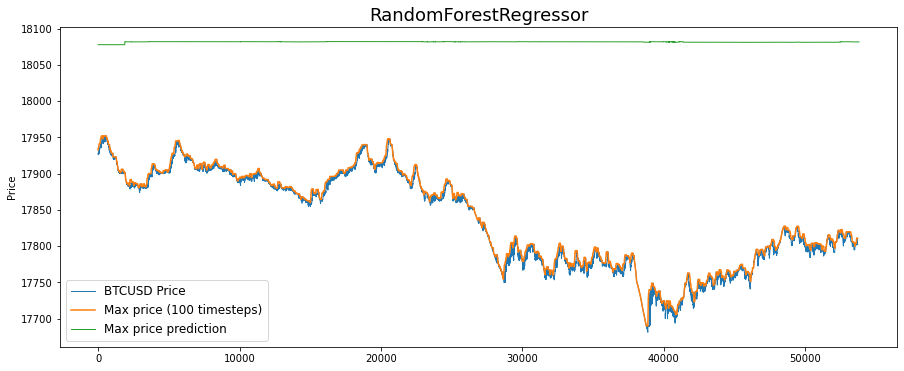

In [8]:
X_price = df_test["price"].values

fig = plt.figure(figsize=(15,20))
ax12 = fig.add_subplot(312)
ax12.plot(X_price,linewidth=1, label='BTCUSD Price')
ax12.plot(y, label='Max price (100 timesteps)')
ax12.plot(rf_plot_pred, linewidth=1, label='Max price prediction')
ax12.set_title("RandomForestRegressor", fontsize=18)
ax12.set_ylabel('Price')
ax12.legend(loc="best", fontsize=12)

plt.show()

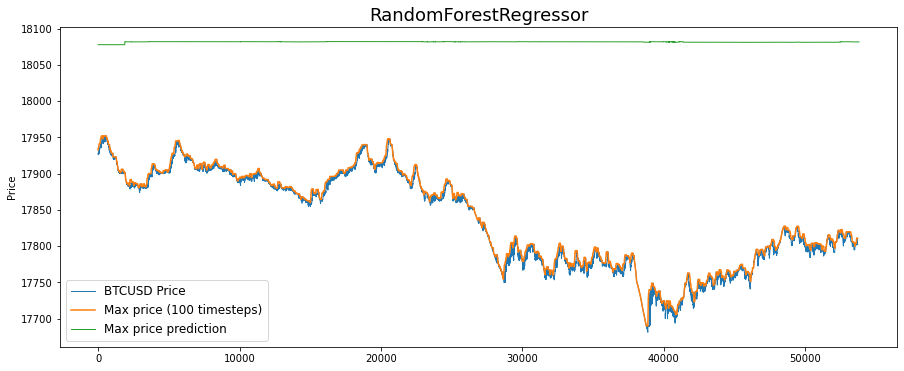

In [9]:
#Importing a image of the plot inside the file, because the people who view this project
#will not have the data, since it is too big to upload it to the repo.
from IPython.display import Image
Image(filename='plot_rf.png')